<strong> Import all libraires that will be used </strong>

In [21]:
from utils import PaintingsDataset, Generator, Unet_Discriminator, Unet_Generator, unet_d_criterion_without_cutmix
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

<strong> Initializing the paintings dataset </strong>

In [22]:
# Building the dataset
image_dir = '../../data/resized/resized/'

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((128,128)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
paintings = PaintingsDataset(image_dir, transform)

<strong> Sampling an element from the dataset and plotting it </strong>

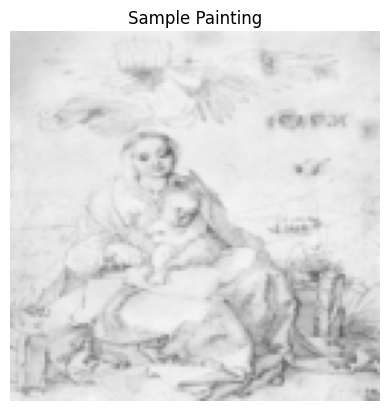

In [23]:
# Sampling randomly an element from the dataset
n = len(paintings)
integer = random.randint(0,n)

# Sampled image
image = paintings[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [24]:
dataloader = DataLoader(paintings, batch_size=16)

<strong> Initializing the parameters of the model </strong>

In [25]:
# Model's parameters
latent_dim = 40
channels_out = 3
channels_in = 3

# Intializing the models
G = Generator(latent_dim, channels_out)
D = Unet_Discriminator(3, 2)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

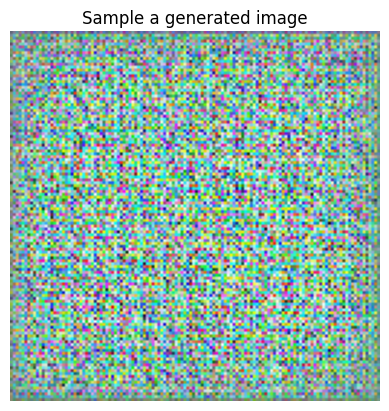

In [26]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# De-normalizing the image
image_generated = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a generated image')
plt.show()

<strong> Let build the training loop</strong>

In [27]:
torch.autograd.set_detect_anomaly(True)

# Parameters
input_channels = 3
n_classes = 2
k = 1  # Steps to train generator
latent_dim = 40
epochs = 300  # Total number of epochs

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out).to(device)  # Ensure latent_dim and channels_out are defined
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)

# Loss function and optimizers
criterion = unet_d_criterion_without_cutmix
optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.99, 0.99))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.99, 0.99))

# For evaluation
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(paintings)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []
D_loss = []
G_loss =  []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Train discriminator
        real_images = batch.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        labels_real = torch.ones(batch_size, 1, device=device)
        labels_fake = torch.zeros(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_real, batch_size)

        # Train discriminator with fake images
        noise = torch.rand(batch_size, latent_dim, 1, 1, device=device) * 2 - 1
        fake_images = G_unet(noise)
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_fake, batch_size)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            G_unet.zero_grad()
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_real, batch_size)  # Labels for generator are real
            loss_g.backward()
            optimizer_g_unet.step()
            D_loss.append(loss_d.item())
            G_loss.append(loss_g.item())
            
    
    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()

        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        # Train mode
        G_unet.train()

    end_time = time.time()
    if epoch % k == 0:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')

    print(f'Epoch {epoch + 1} duration: {end_time - start_time}')


cuda


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [0/300] | Loss D: 22701.83984375 | Loss G: 10502.1591796875
Epoch 1 duration: 89.21420550346375


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/300] | Loss D: 19210.46875 | Loss G: 13675.30078125
Epoch 2 duration: 84.41640734672546


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/300] | Loss D: 15048.529296875 | Loss G: 23990.732421875
Epoch 3 duration: 94.616623878479


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/300] | Loss D: 22982.255859375 | Loss G: 10694.7900390625
Epoch 4 duration: 77.29496312141418


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/300] | Loss D: 22740.576171875 | Loss G: 11542.806640625
Epoch 5 duration: 50.50662326812744


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/300] | Loss D: 22717.486328125 | Loss G: 11501.546875
Epoch 6 duration: 65.18167328834534


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/300] | Loss D: 21948.810546875 | Loss G: 11520.34765625
Epoch 7 duration: 68.01935362815857


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/300] | Loss D: 17077.28515625 | Loss G: 11382.029296875
Epoch 8 duration: 71.89058876037598


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/300] | Loss D: 14652.97265625 | Loss G: 11873.7939453125
Epoch 9 duration: 67.3704137802124


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/300] | Loss D: 12655.3779296875 | Loss G: 12075.82421875
Epoch 10 duration: 68.03620862960815


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/300] | Loss D: 11969.7978515625 | Loss G: 12367.791015625
Epoch 11 duration: 69.88769602775574


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/300] | Loss D: 18402.119140625 | Loss G: 12670.306640625
Epoch 12 duration: 63.497243881225586


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/300] | Loss D: 14493.423828125 | Loss G: 12872.8486328125
Epoch 13 duration: 68.11701250076294


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/300] | Loss D: 11490.4345703125 | Loss G: 13199.8994140625
Epoch 14 duration: 56.11918067932129


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/300] | Loss D: 11818.8466796875 | Loss G: 13483.716796875
Epoch 15 duration: 50.287843465805054


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/300] | Loss D: 19704.751953125 | Loss G: 13802.501953125
Epoch 16 duration: 49.54426383972168


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/300] | Loss D: 18337.2578125 | Loss G: 14014.5712890625
Epoch 17 duration: 50.86274433135986


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/300] | Loss D: 18892.640625 | Loss G: 14143.400390625
Epoch 18 duration: 50.619651079177856


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/300] | Loss D: 10758.2421875 | Loss G: 14240.0361328125
Epoch 19 duration: 50.92374014854431


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/300] | Loss D: 13197.66015625 | Loss G: 14404.8232421875
Epoch 20 duration: 49.69932270050049


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/300] | Loss D: 12276.5478515625 | Loss G: 14591.740234375
Epoch 21 duration: 49.16578006744385


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [21/300] | Loss D: 21138.455078125 | Loss G: 14789.3173828125
Epoch 22 duration: 49.02843999862671


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [22/300] | Loss D: 21376.51953125 | Loss G: 14884.6630859375
Epoch 23 duration: 49.08560585975647


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [23/300] | Loss D: 21302.3828125 | Loss G: 14877.1494140625
Epoch 24 duration: 49.01712703704834


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [24/300] | Loss D: 21437.525390625 | Loss G: 14866.185546875
Epoch 25 duration: 49.092281341552734


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [25/300] | Loss D: 19653.69140625 | Loss G: 15013.357421875
Epoch 26 duration: 48.45180916786194


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [26/300] | Loss D: 19652.93359375 | Loss G: 15231.7666015625
Epoch 27 duration: 49.01031231880188


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [27/300] | Loss D: 19677.8828125 | Loss G: 15479.7939453125
Epoch 28 duration: 49.161197900772095


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [28/300] | Loss D: 23387.814453125 | Loss G: 15722.83984375
Epoch 29 duration: 48.98811221122742


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [29/300] | Loss D: 19723.763671875 | Loss G: 15904.1943359375
Epoch 30 duration: 48.968772649765015


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [30/300] | Loss D: 394883.375 | Loss G: 14080.25
Epoch 31 duration: 60.31297063827515


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [31/300] | Loss D: 23824.810546875 | Loss G: 16194.8134765625
Epoch 32 duration: 50.30389094352722


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [32/300] | Loss D: 23779.982421875 | Loss G: 16073.9599609375
Epoch 33 duration: 49.11951947212219


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [33/300] | Loss D: 23708.19140625 | Loss G: 15858.6279296875
Epoch 34 duration: 49.351651668548584


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [34/300] | Loss D: 23590.01953125 | Loss G: 15598.5009765625
Epoch 35 duration: 48.938560485839844


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [35/300] | Loss D: 23488.455078125 | Loss G: 15321.4384765625
Epoch 36 duration: 55.72846961021423


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [36/300] | Loss D: 23386.08984375 | Loss G: 15019.71875
Epoch 37 duration: 50.998863697052


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [37/300] | Loss D: 23293.482421875 | Loss G: 14738.89453125
Epoch 38 duration: 49.30355739593506


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [38/300] | Loss D: 23298.931640625 | Loss G: 14423.2099609375
Epoch 39 duration: 50.43097162246704


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [39/300] | Loss D: 23215.939453125 | Loss G: 14127.810546875
Epoch 40 duration: 57.64686369895935


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [40/300] | Loss D: 23140.48046875 | Loss G: 13835.673828125
Epoch 41 duration: 96.3147041797638


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [41/300] | Loss D: 23072.779296875 | Loss G: 13547.4482421875
Epoch 42 duration: 388.5309479236603


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [42/300] | Loss D: 23012.921875 | Loss G: 13263.4501953125
Epoch 43 duration: 346.2217814922333


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [43/300] | Loss D: 22960.990234375 | Loss G: 12984.158203125
Epoch 44 duration: 426.22518038749695


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [44/300] | Loss D: 22917.01953125 | Loss G: 12710.0791015625
Epoch 45 duration: 105.46132516860962


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [45/300] | Loss D: 22783.55078125 | Loss G: 12442.0810546875
Epoch 46 duration: 82.24278378486633


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [46/300] | Loss D: 22754.3046875 | Loss G: 12181.46484375
Epoch 47 duration: 63.71301531791687


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [47/300] | Loss D: 22733.845703125 | Loss G: 11928.8935546875
Epoch 48 duration: 109.37841153144836


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [48/300] | Loss D: 22720.81640625 | Loss G: 11689.6796875
Epoch 49 duration: 127.26448178291321


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [49/300] | Loss D: 22716.53125 | Loss G: 11471.3603515625
Epoch 50 duration: 90.48192954063416


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [50/300] | Loss D: 22714.716796875 | Loss G: 11292.767578125
Epoch 51 duration: 86.21312975883484


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [51/300] | Loss D: 22716.19921875 | Loss G: 11187.150390625
Epoch 52 duration: 96.15952181816101


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [52/300] | Loss D: 22716.341796875 | Loss G: 11181.9794921875
Epoch 53 duration: 74.86500597000122


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [53/300] | Loss D: 22715.04296875 | Loss G: 11259.263671875
Epoch 54 duration: 78.16907358169556


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [54/300] | Loss D: 22714.4375 | Loss G: 11368.1123046875
Epoch 55 duration: 86.75351786613464


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [55/300] | Loss D: 22714.7890625 | Loss G: 11434.0634765625
Epoch 56 duration: 102.73128485679626


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [56/300] | Loss D: 22714.576171875 | Loss G: 11404.62890625
Epoch 57 duration: 100.47915816307068


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [57/300] | Loss D: 22714.470703125 | Loss G: 11331.5869140625
Epoch 58 duration: 95.55394124984741


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [58/300] | Loss D: 22714.51171875 | Loss G: 11322.0341796875
Epoch 59 duration: 93.0103440284729


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [59/300] | Loss D: 22714.453125 | Loss G: 11375.8173828125
Epoch 60 duration: 91.25684881210327


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [60/300] | Loss D: 22714.4453125 | Loss G: 11369.7880859375
Epoch 61 duration: 113.5488133430481


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [61/300] | Loss D: 22714.455078125 | Loss G: 11338.3349609375
Epoch 62 duration: 109.24705529212952


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [62/300] | Loss D: 22714.443359375 | Loss G: 11370.228515625
Epoch 63 duration: 109.07858896255493


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [63/300] | Loss D: 22714.4375 | Loss G: 11349.083984375
Epoch 64 duration: 135.92595386505127


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [64/300] | Loss D: 22714.435546875 | Loss G: 11364.1474609375
Epoch 65 duration: 176.81854224205017


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [65/300] | Loss D: 22714.435546875 | Loss G: 11350.23046875
Epoch 66 duration: 183.87740468978882


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [66/300] | Loss D: 22714.435546875 | Loss G: 11361.0126953125
Epoch 67 duration: 156.28222632408142


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [67/300] | Loss D: 22714.43359375 | Loss G: 11360.3251953125
Epoch 68 duration: 174.95950603485107


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [68/300] | Loss D: 22714.43359375 | Loss G: 11356.62109375
Epoch 69 duration: 191.4169647693634


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [69/300] | Loss D: 22714.43359375 | Loss G: 11356.06640625
Epoch 70 duration: 331.50503396987915


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [70/300] | Loss D: 22714.43359375 | Loss G: 11357.361328125
Epoch 71 duration: 143.77247834205627


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [71/300] | Loss D: 22714.43359375 | Loss G: 11358.833984375
Epoch 72 duration: 145.1638617515564


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [72/300] | Loss D: 22714.43359375 | Loss G: 11356.333984375
Epoch 73 duration: 200.95054531097412


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [73/300] | Loss D: 22714.43359375 | Loss G: 11358.142578125
Epoch 74 duration: 142.46036791801453


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [74/300] | Loss D: 22714.43359375 | Loss G: 11357.05078125
Epoch 75 duration: 140.36991357803345


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [75/300] | Loss D: 22714.43359375 | Loss G: 11357.1171875
Epoch 76 duration: 136.90197610855103


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [76/300] | Loss D: 22714.43359375 | Loss G: 11357.69140625
Epoch 77 duration: 148.4526162147522


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [77/300] | Loss D: 22714.43359375 | Loss G: 11356.87890625
Epoch 78 duration: 156.87806153297424


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [78/300] | Loss D: 22714.43359375 | Loss G: 11356.92578125
Epoch 79 duration: 152.26185083389282


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [79/300] | Loss D: 22714.43359375 | Loss G: 11357.251953125
Epoch 80 duration: 142.9932918548584


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [80/300] | Loss D: 22714.43359375 | Loss G: 11357.03515625
Epoch 81 duration: 161.4054732322693


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [81/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 82 duration: 136.61499071121216


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [82/300] | Loss D: 22714.43359375 | Loss G: 11357.103515625
Epoch 83 duration: 139.76994156837463


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [83/300] | Loss D: 22714.43359375 | Loss G: 11357.294921875
Epoch 84 duration: 269.27686643600464


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [84/300] | Loss D: 22714.43359375 | Loss G: 11357.28515625
Epoch 85 duration: 155.8696563243866


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [85/300] | Loss D: 22714.43359375 | Loss G: 11357.271484375
Epoch 86 duration: 156.87150406837463


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [86/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 87 duration: 280.3836102485657


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [87/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 88 duration: 152.68949675559998


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [88/300] | Loss D: 22714.43359375 | Loss G: 11357.244140625
Epoch 89 duration: 160.74430394172668


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [89/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 90 duration: 144.98115801811218


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [90/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 91 duration: 194.50642037391663


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [91/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 92 duration: 114.55667495727539


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [92/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 93 duration: 103.93254256248474


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [93/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 94 duration: 108.98836183547974


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [94/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 95 duration: 93.57250261306763


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [95/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 96 duration: 95.91474914550781


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [96/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 97 duration: 99.55613422393799


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [97/300] | Loss D: 22714.43359375 | Loss G: 11357.19140625
Epoch 98 duration: 93.46675705909729


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [98/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 99 duration: 107.52990460395813


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [99/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 100 duration: 102.10556411743164


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [100/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 101 duration: 99.1150529384613


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [101/300] | Loss D: 22714.43359375 | Loss G: 11357.24609375
Epoch 102 duration: 95.94376277923584


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [102/300] | Loss D: 22714.43359375 | Loss G: 11357.193359375
Epoch 103 duration: 101.64782881736755


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [103/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 104 duration: 103.76918864250183


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [104/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 105 duration: 106.18962621688843


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [105/300] | Loss D: 22714.43359375 | Loss G: 11357.22265625
Epoch 106 duration: 113.94913959503174


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [106/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 107 duration: 126.09935235977173


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [107/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 108 duration: 105.0681381225586


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [108/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 109 duration: 117.07373046875


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [109/300] | Loss D: 22714.43359375 | Loss G: 11357.2109375
Epoch 110 duration: 117.85136103630066


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [110/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 111 duration: 118.18704080581665


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [111/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 112 duration: 105.15247559547424


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [112/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 113 duration: 190.04197883605957


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [113/300] | Loss D: 22714.43359375 | Loss G: 11357.208984375
Epoch 114 duration: 109.7668387889862


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [114/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 115 duration: 117.20150828361511


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [115/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 116 duration: 106.66614890098572


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [116/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 117 duration: 98.1463053226471


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [117/300] | Loss D: 22714.43359375 | Loss G: 11357.2265625
Epoch 118 duration: 96.29484462738037


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [118/300] | Loss D: 22714.43359375 | Loss G: 11357.23828125
Epoch 119 duration: 110.60348796844482


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [119/300] | Loss D: 22714.43359375 | Loss G: 11357.208984375
Epoch 120 duration: 111.16694235801697


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [120/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 121 duration: 139.48720121383667


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [121/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 122 duration: 425.7281804084778


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [122/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 123 duration: 401.97371888160706


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [123/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 124 duration: 367.13983511924744


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [124/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 125 duration: 348.24670600891113


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [125/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 126 duration: 331.64963459968567


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [126/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 127 duration: 373.1797389984131


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [127/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 128 duration: 333.404025554657


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [128/300] | Loss D: 22714.43359375 | Loss G: 11357.248046875
Epoch 129 duration: 327.1719219684601


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [129/300] | Loss D: 22714.43359375 | Loss G: 11357.18359375
Epoch 130 duration: 276.1381325721741


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [130/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 131 duration: 208.945294380188


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [131/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 132 duration: 209.19626593589783


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [132/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 133 duration: 237.9602518081665


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [133/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 134 duration: 224.286705493927


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [134/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 135 duration: 199.89884281158447


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [135/300] | Loss D: 22714.43359375 | Loss G: 11357.193359375
Epoch 136 duration: 159.6101016998291


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [136/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 137 duration: 163.34414625167847


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [137/300] | Loss D: 22714.43359375 | Loss G: 11357.189453125
Epoch 138 duration: 161.03474760055542


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [138/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 139 duration: 161.2724151611328


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [139/300] | Loss D: 22714.43359375 | Loss G: 11357.17578125
Epoch 140 duration: 155.7234492301941


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [140/300] | Loss D: 22714.43359375 | Loss G: 11357.251953125
Epoch 141 duration: 192.25119805335999


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [141/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 142 duration: 225.1853368282318


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [142/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 143 duration: 161.55513310432434


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [143/300] | Loss D: 22714.43359375 | Loss G: 11357.189453125
Epoch 144 duration: 155.12979578971863


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [144/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 145 duration: 158.63804244995117


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [145/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 146 duration: 220.3388168811798


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [146/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 147 duration: 310.27337527275085


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [147/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 148 duration: 414.69518995285034


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [148/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 149 duration: 321.91485261917114


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [149/300] | Loss D: 22714.43359375 | Loss G: 11357.208984375
Epoch 150 duration: 1001.5044815540314


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [150/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 151 duration: 235.18734335899353


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [151/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 152 duration: 60.72112250328064


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [152/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 153 duration: 62.79314732551575


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [153/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 154 duration: 63.38759231567383


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [154/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 155 duration: 63.39456605911255


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [155/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 156 duration: 63.81484627723694


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [156/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 157 duration: 64.17354702949524


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [157/300] | Loss D: 22714.43359375 | Loss G: 11357.23828125
Epoch 158 duration: 65.34724545478821


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [158/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 159 duration: 63.847166538238525


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [159/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 160 duration: 63.539780616760254


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [160/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 161 duration: 65.01624417304993


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [161/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 162 duration: 56.41703701019287


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [162/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 163 duration: 55.22007608413696


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [163/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 164 duration: 52.0416305065155


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [164/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 165 duration: 59.021894216537476


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [165/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 166 duration: 66.35271000862122


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [166/300] | Loss D: 22714.43359375 | Loss G: 11357.208984375
Epoch 167 duration: 66.19778847694397


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [167/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 168 duration: 68.90766215324402


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [168/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 169 duration: 62.904207706451416


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [169/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 170 duration: 71.34992218017578


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [170/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 171 duration: 73.11745738983154


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [171/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 172 duration: 72.06103920936584


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [172/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 173 duration: 67.40675234794617


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [173/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 174 duration: 59.761571645736694


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [174/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 175 duration: 68.45660066604614


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [175/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 176 duration: 63.88056039810181


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [176/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 177 duration: 64.4981586933136


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [177/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 178 duration: 69.02181339263916


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [178/300] | Loss D: 22714.43359375 | Loss G: 11357.255859375
Epoch 179 duration: 59.279963970184326


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [179/300] | Loss D: 22714.43359375 | Loss G: 11357.24609375
Epoch 180 duration: 70.09802269935608


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [180/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 181 duration: 93.07322812080383


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [181/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 182 duration: 63.966872453689575


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [182/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 183 duration: 59.048789501190186


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [183/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 184 duration: 58.61382293701172


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [184/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 185 duration: 59.17145895957947


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [185/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 186 duration: 59.31237244606018


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [186/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 187 duration: 62.47028565406799


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [187/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 188 duration: 60.749669790267944


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [188/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 189 duration: 60.617985248565674


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [189/300] | Loss D: 22714.43359375 | Loss G: 11357.23828125
Epoch 190 duration: 62.872151374816895


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [190/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 191 duration: 61.56362581253052


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [191/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 192 duration: 60.900477170944214


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [192/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 193 duration: 59.99192261695862


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [193/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 194 duration: 62.41910672187805


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [194/300] | Loss D: 22714.43359375 | Loss G: 11357.19140625
Epoch 195 duration: 64.68214178085327


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [195/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 196 duration: 63.82235884666443


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [196/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 197 duration: 62.13996076583862


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [197/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 198 duration: 62.803210735321045


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [198/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 199 duration: 61.22225332260132


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [199/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 200 duration: 60.653547286987305


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [200/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 201 duration: 62.03508377075195


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [201/300] | Loss D: 22714.43359375 | Loss G: 11357.255859375
Epoch 202 duration: 60.47036862373352


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [202/300] | Loss D: 22714.43359375 | Loss G: 11357.24609375
Epoch 203 duration: 61.5976037979126


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [203/300] | Loss D: 22714.43359375 | Loss G: 11357.189453125
Epoch 204 duration: 64.5623254776001


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [204/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 205 duration: 61.93388271331787


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [205/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 206 duration: 63.0114905834198


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [206/300] | Loss D: 22714.43359375 | Loss G: 11357.19140625
Epoch 207 duration: 63.71347618103027


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [207/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 208 duration: 61.6468300819397


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [208/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 209 duration: 62.14981389045715


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [209/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 210 duration: 62.41212558746338


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [210/300] | Loss D: 22714.43359375 | Loss G: 11357.1953125
Epoch 211 duration: 73.43517470359802


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [211/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 212 duration: 86.9356758594513


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [212/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 213 duration: 85.405592918396


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [213/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 214 duration: 83.7389874458313


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [214/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 215 duration: 82.04047226905823


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [215/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 216 duration: 87.13594055175781


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [216/300] | Loss D: 22714.43359375 | Loss G: 11357.244140625
Epoch 217 duration: 84.6987316608429


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [217/300] | Loss D: 22714.43359375 | Loss G: 11357.197265625
Epoch 218 duration: 85.25899720191956


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [218/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 219 duration: 84.6138129234314


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [219/300] | Loss D: 22714.43359375 | Loss G: 11357.2265625
Epoch 220 duration: 102.42692828178406


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [220/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 221 duration: 120.165522813797


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [221/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 222 duration: 130.33137559890747


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [222/300] | Loss D: 22714.43359375 | Loss G: 11357.197265625
Epoch 223 duration: 118.06523275375366


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [223/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 224 duration: 106.81905126571655


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [224/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 225 duration: 130.86032032966614


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [225/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 226 duration: 125.9980936050415


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [226/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 227 duration: 120.87945556640625


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [227/300] | Loss D: 22714.43359375 | Loss G: 11357.244140625
Epoch 228 duration: 127.31371259689331


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [228/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 229 duration: 107.12371611595154


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [229/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 230 duration: 122.16415524482727


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [230/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 231 duration: 125.11204218864441


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [231/300] | Loss D: 22714.43359375 | Loss G: 11357.2265625
Epoch 232 duration: 121.29061198234558


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [232/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 233 duration: 127.52346777915955


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [233/300] | Loss D: 22714.43359375 | Loss G: 11357.2109375
Epoch 234 duration: 124.77816033363342


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [234/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 235 duration: 118.01048946380615


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [235/300] | Loss D: 22714.43359375 | Loss G: 11357.2109375
Epoch 236 duration: 129.12071347236633


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [236/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 237 duration: 110.13581967353821


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [237/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 238 duration: 127.83659076690674


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [238/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 239 duration: 126.20173978805542


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [239/300] | Loss D: 22714.43359375 | Loss G: 11357.248046875
Epoch 240 duration: 113.09404492378235


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [240/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 241 duration: 137.01718258857727


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [241/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 242 duration: 97.54947185516357


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [242/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 243 duration: 96.34561324119568


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [243/300] | Loss D: 22714.43359375 | Loss G: 11357.2109375
Epoch 244 duration: 91.34078907966614


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [244/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 245 duration: 95.6313624382019


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [245/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 246 duration: 107.53545904159546


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [246/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 247 duration: 97.15805554389954


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [247/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 248 duration: 65.39885187149048


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [248/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 249 duration: 61.365734815597534


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [249/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 250 duration: 60.68370294570923


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [250/300] | Loss D: 22714.43359375 | Loss G: 11357.197265625
Epoch 251 duration: 61.52832841873169


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [251/300] | Loss D: 22714.43359375 | Loss G: 11357.197265625
Epoch 252 duration: 61.74349784851074


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [252/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 253 duration: 63.258506059646606


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [253/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 254 duration: 62.84201455116272


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [254/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 255 duration: 61.80856513977051


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [255/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 256 duration: 61.06014156341553


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [256/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 257 duration: 62.6216254234314


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [257/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 258 duration: 62.49681806564331


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [258/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 259 duration: 63.46503520011902


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [259/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 260 duration: 63.67914152145386


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [260/300] | Loss D: 22714.43359375 | Loss G: 11357.20703125
Epoch 261 duration: 74.64162969589233


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [261/300] | Loss D: 22714.43359375 | Loss G: 11357.248046875
Epoch 262 duration: 103.20511436462402


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [262/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 263 duration: 95.743647813797


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [263/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 264 duration: 102.08511805534363


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [264/300] | Loss D: 22714.43359375 | Loss G: 11357.197265625
Epoch 265 duration: 99.11725854873657


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [265/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 266 duration: 101.48709797859192


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [266/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 267 duration: 96.63572359085083


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [267/300] | Loss D: 22714.43359375 | Loss G: 11357.2109375
Epoch 268 duration: 103.87068748474121


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [268/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 269 duration: 97.32603192329407


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [269/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 270 duration: 93.56269931793213


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [270/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 271 duration: 86.5714921951294


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [271/300] | Loss D: 22714.43359375 | Loss G: 11357.19921875
Epoch 272 duration: 70.57048010826111


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [272/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 273 duration: 111.26576542854309


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [273/300] | Loss D: 22714.43359375 | Loss G: 11357.228515625
Epoch 274 duration: 122.37775874137878


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [274/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 275 duration: 126.90525817871094


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [275/300] | Loss D: 22714.43359375 | Loss G: 11357.2421875
Epoch 276 duration: 122.99115347862244


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [276/300] | Loss D: 22714.43359375 | Loss G: 11357.185546875
Epoch 277 duration: 122.60896754264832


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [277/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 278 duration: 124.89274311065674


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [278/300] | Loss D: 22714.43359375 | Loss G: 11357.23046875
Epoch 279 duration: 124.57293343544006


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [279/300] | Loss D: 22714.43359375 | Loss G: 11357.220703125
Epoch 280 duration: 124.44402766227722


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [280/300] | Loss D: 22714.43359375 | Loss G: 11357.232421875
Epoch 281 duration: 120.63647103309631


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [281/300] | Loss D: 22714.43359375 | Loss G: 11357.234375
Epoch 282 duration: 120.86470341682434


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [282/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 283 duration: 121.60448288917542


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [283/300] | Loss D: 22714.43359375 | Loss G: 11357.189453125
Epoch 284 duration: 121.33399319648743


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [284/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 285 duration: 120.19272255897522


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [285/300] | Loss D: 22714.43359375 | Loss G: 11357.208984375
Epoch 286 duration: 123.46722102165222


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [286/300] | Loss D: 22714.43359375 | Loss G: 11357.205078125
Epoch 287 duration: 124.86443209648132


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [287/300] | Loss D: 22714.43359375 | Loss G: 11357.244140625
Epoch 288 duration: 120.43502426147461


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [288/300] | Loss D: 22714.43359375 | Loss G: 11357.203125
Epoch 289 duration: 126.45918536186218


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [289/300] | Loss D: 22714.43359375 | Loss G: 11357.216796875
Epoch 290 duration: 763.16885638237


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [290/300] | Loss D: 22714.43359375 | Loss G: 11357.21875
Epoch 291 duration: 125.65607619285583


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [291/300] | Loss D: 22714.43359375 | Loss G: 11357.212890625
Epoch 292 duration: 142.36127519607544


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [292/300] | Loss D: 22714.43359375 | Loss G: 11357.181640625
Epoch 293 duration: 132.49238348007202


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [293/300] | Loss D: 22714.43359375 | Loss G: 11357.193359375
Epoch 294 duration: 130.1468117237091


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [294/300] | Loss D: 22714.43359375 | Loss G: 11357.236328125
Epoch 295 duration: 139.02390933036804


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [295/300] | Loss D: 22714.43359375 | Loss G: 11357.21484375
Epoch 296 duration: 131.63765454292297


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [296/300] | Loss D: 22714.43359375 | Loss G: 11357.240234375
Epoch 297 duration: 140.1216139793396


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [297/300] | Loss D: 22714.43359375 | Loss G: 11357.19140625
Epoch 298 duration: 142.10632991790771


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [298/300] | Loss D: 22714.43359375 | Loss G: 11357.201171875
Epoch 299 duration: 136.10579347610474


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [299/300] | Loss D: 22714.43359375 | Loss G: 11357.224609375
Epoch 300 duration: 132.951988697052


In [28]:
torch.save(D_unet.state_dict(), "models/d_unet.pth")
torch.save(G_unet.state_dict(), "models/g_unet.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 128, 128])


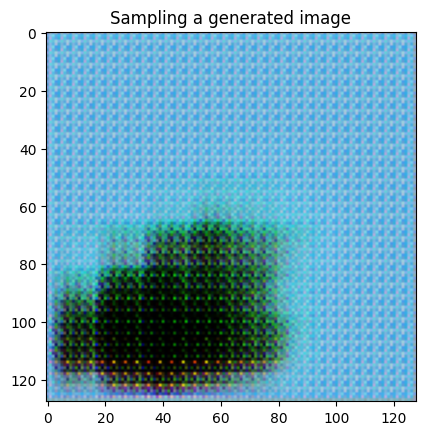

In [32]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

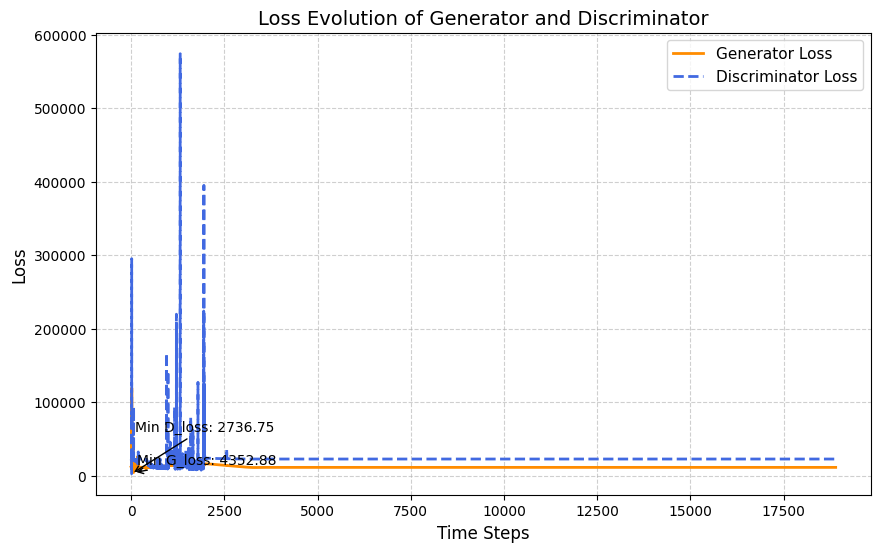

In [30]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

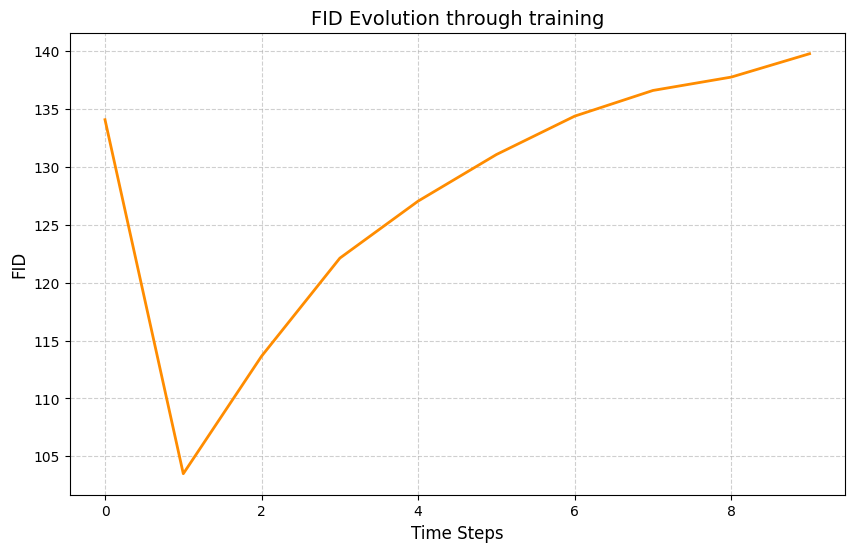

In [31]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)